In [1]:
from tvb.simulator.lab import *
import numpy as np
from tvb.simulator.backend.dopa_backend import DOPABackend
from tvb.simulator.backend.nb_mpr import NbMPRBackend
import matplotlib.pyplot as plt

/Users/martinbreyton/INS_Code/tvb-root/tvb_library/tvb/datatypes/surfaces.py:60: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


In [2]:
# load connectivities
conn_dopamine=np.load("conn_dopamine.npy")
conn_excitator=np.load("conn_excitator.npy")
conn_inhibitor=np.load("conn_inhibitor.npy")

# configure connectivy for TVB
conn = connectivity.Connectivity()
conn.region_labels = np.array(["L.BSTS", "L.CACG", "L.CMFG", "L.CU", "L.EC", "L.FG", "L.IPG", "L.ITG", "L.ICG","L.LOG", "L.LOFG", "L.LG", "L.MOFG", "L.MTG", "L.PHIG", "L.PaCG", "L.POP", "L.POR","L.PTR", "L.PCAL", "L.PoCG", "L.PCG", "L.PrCG", "L.PCU", "L.RACG", "L.RMFG", "L.SFG",
    "L.SPG", "L.STG", "L.SMG", "L.FP", "L.TP", "L.TTG", "L.IN", "L.CER", "L.TH", "L.CA","L.PU", "L.HI", "L.AC", "lh-GPe", "lh-GPi", "lh-STN", "rh-GPe","rh-GPi", "rh-STN", "R.TH", "R.CA", "R.PU", "R.HI",  "R.AC", "R.BSTS",
    "R.CACG", "R.CMFG", "R.CU", "R.EC", "R.FG", "R.IPG", "R.ITG", "R.ICG", "R.LOG","R.LOFG", "R.LG", "R.MOFG", "R.MTG", "R.PHIG", "R.PaCG", "R.POP", "R.POR", "R.PTR","R.PCAL", "R.PoCG", "R.PCG", "R.PrCG", "R.PCU", "R.RACG", "R.RMFG", "R.SFG", "R.SPG",
    "R.STG", "R.SMG", "R.FP", "R.TP", "R.TTG", "R.IN", "R.CER","SubstantiaNigraLH","SubstantiaNigraRH"])
conn.centres = np.zeros((3,88)) # just some trick to create the object in TVB
conn.weights = conn_excitator # inhibitory and dopamine connectivity has to be introduced later (multiple connectivites not implemented in TVB)
conn.tract_lengths = (conn_excitator*.0+100).astype('i') # another trick, we won't be using delays
conn.configure()

# Example : Montbio, Pazo, Roxin model


$$\begin{align*}
\dot{r} = \frac{​​\Delta​​}{\pi} +2rv \\
\dot{v} = v^2 + \bar{\eta} + Jr + I(t) - \pi^2r^2
\end{align*}$$

Two coupled differential equations with parameters $\Delta$, $\bar{\eta}$, $J$

In [3]:
nmm = models.MontbrioPazoRoxin(
        eta   = np.r_[-5.0],
        J     = np.r_[15.],
        Delta = np.r_[1.],
    )
global_coupling = np.array([.56])
dt = 0.01
nsigma = 0.035
sim = simulator.Simulator(
    model=nmm,
    connectivity=conn,
    coupling=coupling.Linear(
        a=global_coupling
    ),
    conduction_speed=20.,
    integrator=integrators.HeunStochastic(
        dt=dt,
        noise=noise.Additive(
            nsig=np.array(
                [nsigma,nsigma*2]
            ), 
            noise_seed=42)
    ),
    monitors=[
        monitors.TemporalAverage(period=0.1) # we rescale time later, to "slow down" the system
    ]
).configure()

In [5]:
mpr_backend = NbMPRBackend()
(t, tavg_base), = mpr_backend.run_sim(sim, simulation_length=10000, compatibility_mode=True)


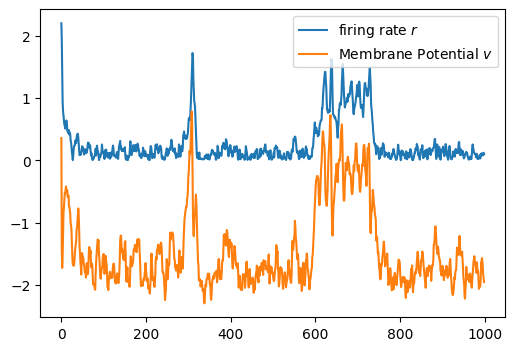

In [6]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.plot(tavg_base[:1000,0,1,0], label='firing rate $r$')
ax.plot(tavg_base[:1000,1,1,0], label='Membrane Potential $v$')
ax.legend(loc='upper right')

In this plot we see the first node jumping from the downstate (low firing rate $\approx$ 0) to the upstate (high firing rate $\approx$ 1)  and back

Text(0, 0.5, '$v$')

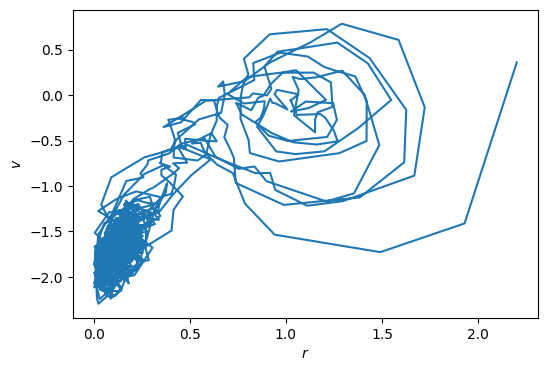

In [7]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.plot(tavg_base[:1000,0,1,0], tavg_base[:1000,1,1,0])
ax.set_xlabel('$r$')
ax.set_ylabel('$v$')

In this joint plot of $r$ and $v$ we visualize the trajectory of the system in the state space, there is a stable fixed point in the lower left corner and a stable focus in the upper right part. Connectivity and noise induce the switches between the two states.

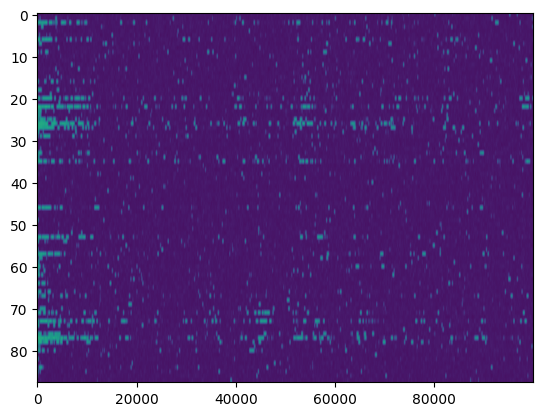

In [8]:
plt.imshow(tavg_base[:,0,:,0].T, aspect='auto', vmax=2.)

## Modifying a global parameter : the coupling

The global coupling is a scalar that scales the connectome, see in the following TVB equation its infuence :

\begin{align*}
    \dot{\psi_i}=\mathcal{N}(\psi_i,\{k\})+g*\sum_{j}G_{ij}S(\psi_j(t-\tau_{ij})) + \xi(t)
\end{align*}

$G_{ij}$ is the connecivity between node i and j. The small $g$ is the global coupling that scales the influence of the structural connectivity. \
Next we increase $g$ from $0.55$ to $0.9$ and see what happends :

In [28]:
del sim

In [29]:
nmm = models.MontbrioPazoRoxin(
        eta   = np.r_[-5.0],
        J     = np.r_[15.],
        Delta = np.r_[1.],
    )
global_coupling = np.array([.9]) # We increase the global coupling
dt = 0.01
nsigma = 0.035
sim = simulator.Simulator(
    model=nmm,
    connectivity=conn,
    coupling=coupling.Linear(
        a=global_coupling
    ),
    conduction_speed=20.,
    integrator=integrators.HeunStochastic(
        dt=dt,
        noise=noise.Additive(
            nsig=np.array(
                [nsigma,nsigma*2]
            ), 
            noise_seed=42)
    ),
    monitors=[
        monitors.TemporalAverage(period=0.1) # we rescale time later, to "slow down" the system
    ]
).configure()

In [11]:
(t, tavg_base2), = mpr_backend.run_sim(sim, simulation_length=10000, compatibility_mode=False)

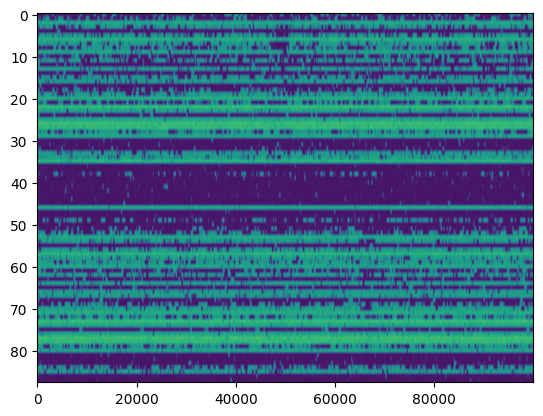

In [30]:
plt.imshow(tavg_base2[:,0,:,0].T, aspect='auto', vmax=2.)

By increasing the global coupling, we have reinforce the functional communications between every nodes, the state of the whole network is somewhat static. The nodes receiving a lot of connections through the connectome tend to be stuck in the upstate and the nodes that a not very connected, in the downstate. We can verify this by plotting the average value of the firing againt the sum of all connections for every node :

Text(0, 0.5, 'average firing rate')

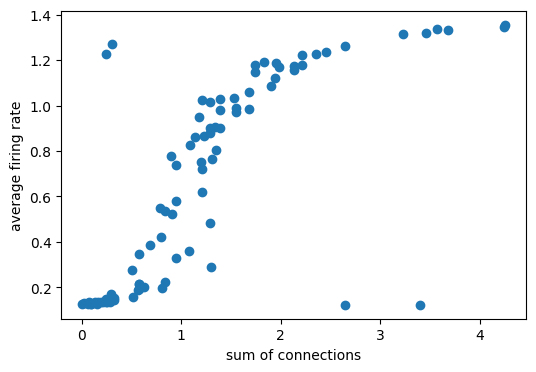

In [27]:
avg_activity = np.mean(tavg_base2[:,0,:,0], axis=0)
sum_connections = np.sum(conn.weights, axis=0)
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.scatter(sum_connections, avg_activity)
ax.set_xlabel('sum of connections')
ax.set_ylabel('average firing rate')

Except for a few outliers, the mode a node is connected to the rest of the network, the more it will spend time in the upstate

# Modifying a neural mass model parameter : $\bar{\eta}$

In the equation of the Montbrio mode, $\bar{\eta}$ captures the mode of the distribution of the excitability across all QIF neurons (at the lower scale). For an individual QIF neuron i, the parameter $\eta_i$ modulates the propensity of a neuron to fire given some input. We changing $\bar{\eta}$ which the whole distribution towards lower or higher excitability. In what follows, with lower $\bar{\eta}$.

In [32]:
del sim

NameError: name 'sim' is not defined

In [15]:
nmm = models.MontbrioPazoRoxin(
        eta   = np.r_[-8.0], # We now change the excitibality parameter of every neural mass in the network
        J     = np.r_[15.],
        Delta = np.r_[1.],
    )
global_coupling = np.array([.9]) # We increase the global coupling
dt = 0.01
nsigma = 0.035
sim = simulator.Simulator(
    model=nmm,
    connectivity=conn,
    coupling=coupling.Linear(
        a=global_coupling
    ),
    conduction_speed=20.,
    integrator=integrators.HeunStochastic(
        dt=dt,
        noise=noise.Additive(
            nsig=np.array(
                [nsigma,nsigma*2]
            ), 
            noise_seed=42)
    ),
    monitors=[
        monitors.TemporalAverage(period=0.1) # we rescale time later, to "slow down" the system
    ]
).configure()

In [16]:
(t, tavg_base3), = mpr_backend.run_sim(sim, simulation_length=10000, compatibility_mode=False)

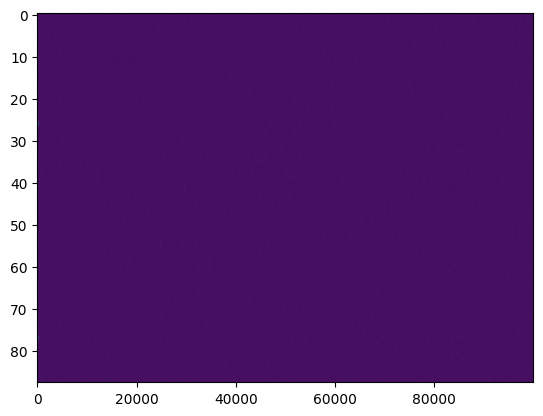

In [33]:
plt.imshow(tavg_base3[:,0,:,0].T, aspect='auto')

It seems like nothing is happening... Really ? Let's look at one node :

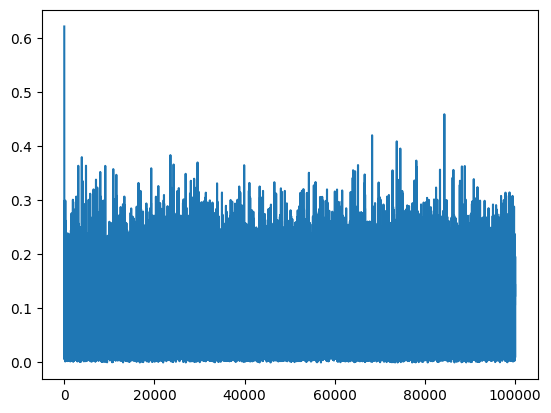

In [20]:
plt.plot(tavg_base3[:,0,0,0])

Or ten nodes

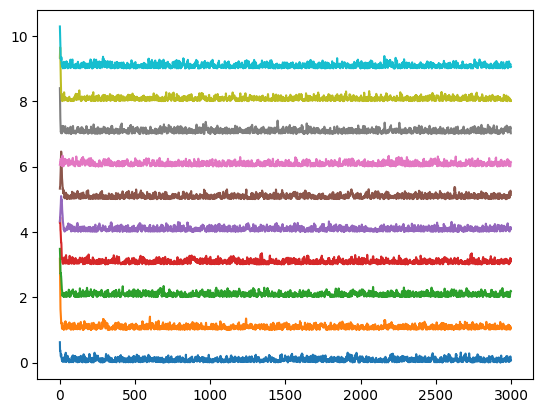

In [22]:
plt.plot(np.arange(10)+ tavg_base3[:3000,0,:10,0])
plt.show()

All nodes are stuck in the downstate and no activity is spread through the network, their activity is still driven by noise but nothing emerging from the network.

# Dopamine model